# Imports

In [99]:
import pandas                 as pd
import numpy                  as np

import seaborn                as sns
import scikitplot             as skplt #pip install scikit-plot 

from   matplotlib             import pyplot as plt
from   matplotlib             import pylab
from   pylab                  import *
import missingno                                   as msno
from boruta               import BorutaPy

from   sklearn                import preprocessing as pp
from   sklearn                import model_selection as ms
from   sklearn                import ensemble as en
from   sklearn                import neighbors as nh
from   sklearn                import linear_model    as lm
from   sklearn.ensemble       import RandomForestClassifier
import pickle                 as pkl
from   flask                  import Flask, request, Response
import requests
import json
import os
from   IPython.display        import Image
import scipy.stats            as ss
import psycopg2
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
from IPython.core.display  import HTML



## Helper Functions

In [111]:
def create_connection_database(host_name, port_num, database_name, user_name, password_name):
    connection = None
    connection = psycopg2.connect(
                        host = host_name,
                        port = port_num,
                        database = database_name,
                        user = user_name,
                        password = password_name)
    return connection

def corr_cramer_v(categorical_attributes):
    cat_attributes_list = categorical_attributes.columns.tolist()

    corr_dict={}

    for i in range(len(cat_attributes_list)):
        corr_list=[]
        for j in range(len(cat_attributes_list)):
            ref=cat_attributes_list[i]
            feat=cat_attributes_list[j]
            corr = cramer_v(categorical_attributes[ref],categorical_attributes[feat])
            corr_list.append(corr)
        corr_dict[ref]= corr_list
    return corr_dict

def precision_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

def recall_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = [20, 8]
    plt.rcParams['font.size'] = 24
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'Ubuntu'
    plt.rcParams['font.monospace'] = 'Ubuntu Mono'
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 15
    plt.rcParams['xtick.labelsize'] = 6
    plt.rcParams['ytick.labelsize'] = 10
    plt.rcParams['legend.fontsize'] = 12
    plt.rcParams['figure.titlesize'] = 12
    
    display( HTML( '<style>.container { width:70% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    #sns.set()
    sns.set_style('ticks')
    
# Supress Scientific Notation
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.2f}'.format)

In [6]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Loading Dataset

In [7]:
# #connect to the DB
# host_name     = "comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com"
# port_num      = 5432 
# database_name = "comunidadedsdb"
# user_name     = "member"
# password_name = "xxxxxxx"

# #make connection with DB
# conn = create_connection_database (host_name, port_num, database_name, user_name, password_name)

# #checking tables in schema
# cur = conn.cursor()

# cur.execute("""SELECT table_schema, table_name
#                       FROM information_schema.tables
#                       WHERE table_schema != 'pg_catalog'
#                       AND table_schema != 'information_schema'
#                       AND table_type='BASE TABLE'
#                       ORDER BY table_schema, table_name""")

# schemas_db = cur.fetchall()

# # cursor close
# cur.close()

# df_insurance = sqlio.read_sql_query("Select * from pa004.insurance", conn)
# df_vehicle = sqlio.read_sql_query("Select * from pa004.vehicle", conn)
# df_users = sqlio.read_sql_query("Select * from pa004.users", conn)

# #close the connection
# conn.close()

# #checking each shape of dataframes
# print('Tables shape:\n Insurance: {}\n Vehicle: {}\n Users: {}'.format(df_insurance.shape,df_vehicle.shape, df_users.shape ))

In [8]:
# df0 = df_users.merge(df_vehicle, how = 'outer', on='id')
# df0 = df0.merge(df_insurance, how = 'outer', on='id')

# #cleaning memory of dataframes used to collect data from DB
# df_vehicle = None
# df_users = None
# df_insurance = None

# df0.sample(5)

In [9]:
df_raw = pd.read_csv('../health_insurance_cross_sell/data/raw/train.csv')
print('Number of Rows df_raw: {}'.format(df_raw.shape[0]))

Number of Rows df_raw: 381109


In [10]:
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.00,0,> 2 Years,Yes,40454.00,26.00,217,1
1,2,Male,76,1,3.00,0,1-2 Year,No,33536.00,26.00,183,0
2,3,Male,47,1,28.00,0,> 2 Years,Yes,38294.00,26.00,27,1
3,4,Male,21,1,11.00,1,< 1 Year,No,28619.00,152.00,203,0
4,5,Female,29,1,41.00,1,< 1 Year,No,27496.00,152.00,39,0


## Separating  test data 

In [11]:
X_test = df_raw.drop(['Response'], axis = 1)
y_test = df_raw['Response'].copy()

df0, X_test, y0, y_test = ms.train_test_split(X_test,y_test,test_size=0.1)

df0 = pd.concat([df0, y0], axis = 1)

In [12]:
df_test = X_test
df_test.to_csv('data/raw/df_test.csv')

# Data Description

In [13]:
df1 = df0.copy()

## Data Dimension

In [14]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Columns: {}'.format( df1.shape[1] ) )

Number of Rows: 342998
Number of Columns: 12


## Rename Columns

In [15]:
df1.columns = map(str.lower, df1.columns)

## Data Types

In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342998 entries, 160482 to 373482
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    342998 non-null  int64  
 1   gender                342998 non-null  object 
 2   age                   342998 non-null  int64  
 3   driving_license       342998 non-null  int64  
 4   region_code           342998 non-null  float64
 5   previously_insured    342998 non-null  int64  
 6   vehicle_age           342998 non-null  object 
 7   vehicle_damage        342998 non-null  object 
 8   annual_premium        342998 non-null  float64
 9   policy_sales_channel  342998 non-null  float64
 10  vintage               342998 non-null  int64  
 11  response              342998 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.0+ MB


### Columns Description

- **Id**: Customer identifier 
- **Gender**: Gender of customer
- **Age**: Age of customer
- **Driving License**: 0 if customer does not have the permission for drive; 1 if customer has the permission for drive
- **Region Code**: Region code of customer
- **Previously Insured**: 0 if customer does not have a vehicle insurance; 1 if customer already has a vehicle insurance.
- **Vehicle Age**: Age of vehicle
- **Vehicle Damage**: 0 if customer never got involved in a previous vehicle damage; 1 if customer already had a vehicle damage
- **Annual Premium**: amount paid for health insurance to the company anualy.
- **Policy sales channel**: anonymous code for contact with customer.
- **Vintage**: time (in days) that customer bought his health assurance.
- **Response**: 0 if customer has no interest in product; 1 if customer has interest in product

## Check NA

In [17]:
aux=df1.isna().sum().sort_values(ascending=False)
aux1=df1.isna().sum().sort_values(ascending=False)/df1.shape[0]*100

NaN=pd.concat([aux,aux1],axis=1)
NaN.columns=['NaN', 'NaN %']
NaN

,NaN,NaN %
id,0,0.00
gender,0,0.00
age,0,0.00
driving_license,0,0.00
region_code,0,0.00
previously_insured,0,0.00
vehicle_age,0,0.00
vehicle_damage,0,0.00
annual_premium,0,0.00
policy_sales_channel,0,0.00


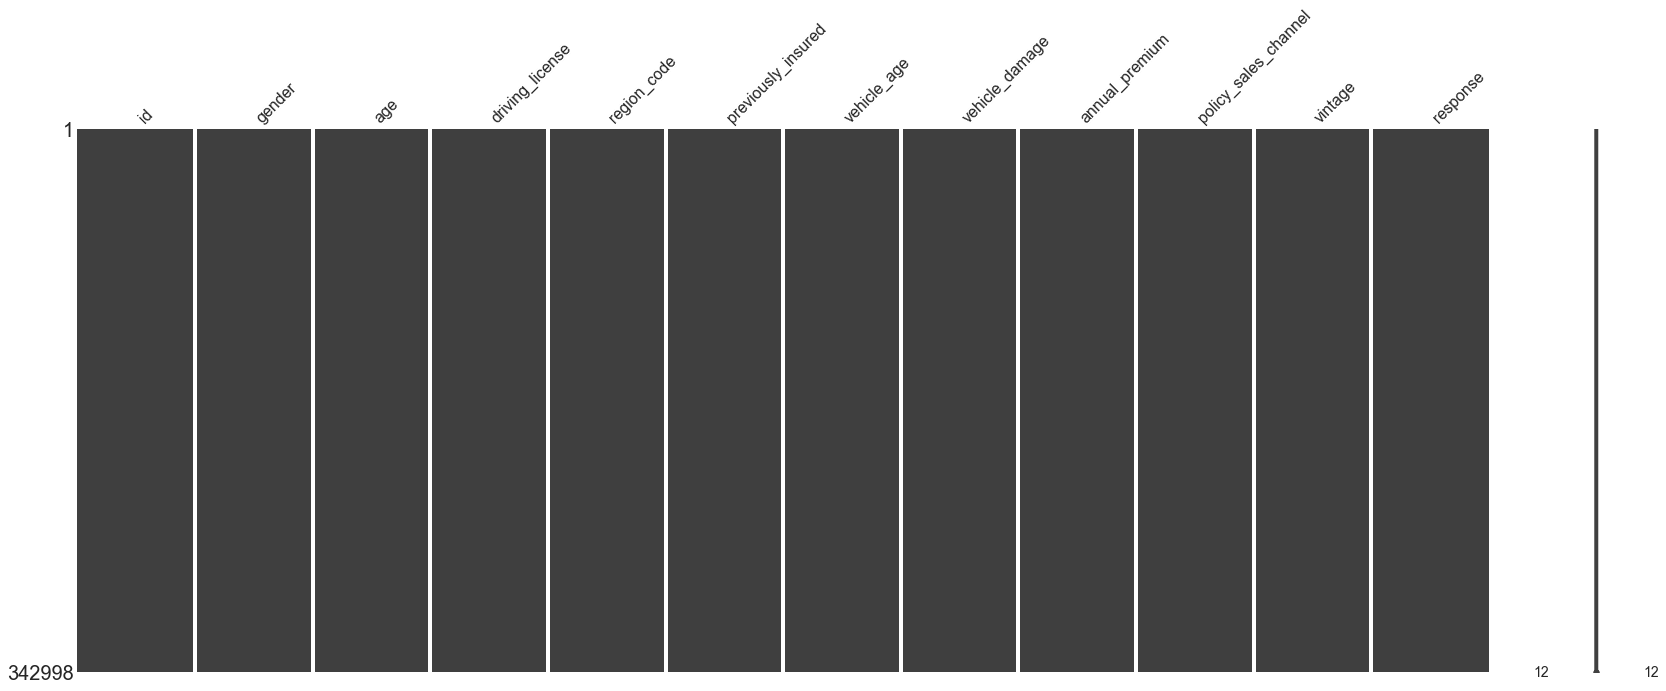

In [18]:
%matplotlib inline
msno.matrix(df1);

## Data Descriptive

In [19]:
num_attributes = df1[['age', 'annual_premium', 'vintage']]

cat_attributes = df1[['driving_license', 'previously_insured', 'vehicle_damage', 'vehicle_age', 'gender', 'region_code', 'policy_sales_channel' ]]

target_atribute = df1['response']

 ### Numerical Attributes

In [20]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.00,85.00,65.00,38.81,36.00,15.51,0.67,-0.56
1,annual_premium,2630.00,540165.00,537535.00,30566.51,31663.00,17216.44,1.77,34.17
2,vintage,10.00,299.00,289.00,154.29,154.00,83.66,0.00,-1.20


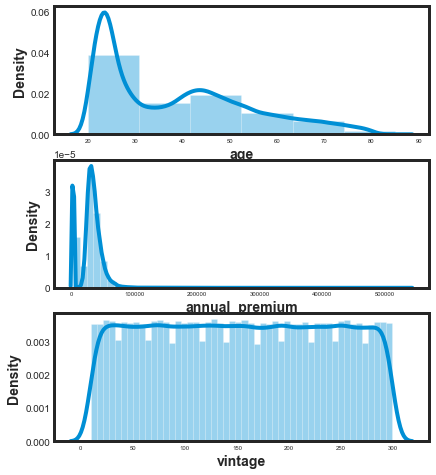

In [21]:
fig, axs = plt.subplots(3, figsize = (6,8))
sns.distplot(df1['age'], ax=axs[0], bins = 6)
sns.distplot(df1['annual_premium'], ax=axs[1])
sns.distplot(df1['vintage'], ax=axs[2]);

### Categorical Attributes

In [22]:
cat_attributes.apply(lambda x: x.unique().shape[0])

driving_license           2
previously_insured        2
vehicle_damage            2
vehicle_age               3
gender                    2
region_code              53
policy_sales_channel    154
dtype: int64

<AxesSubplot:xlabel='region_code', ylabel='count'>

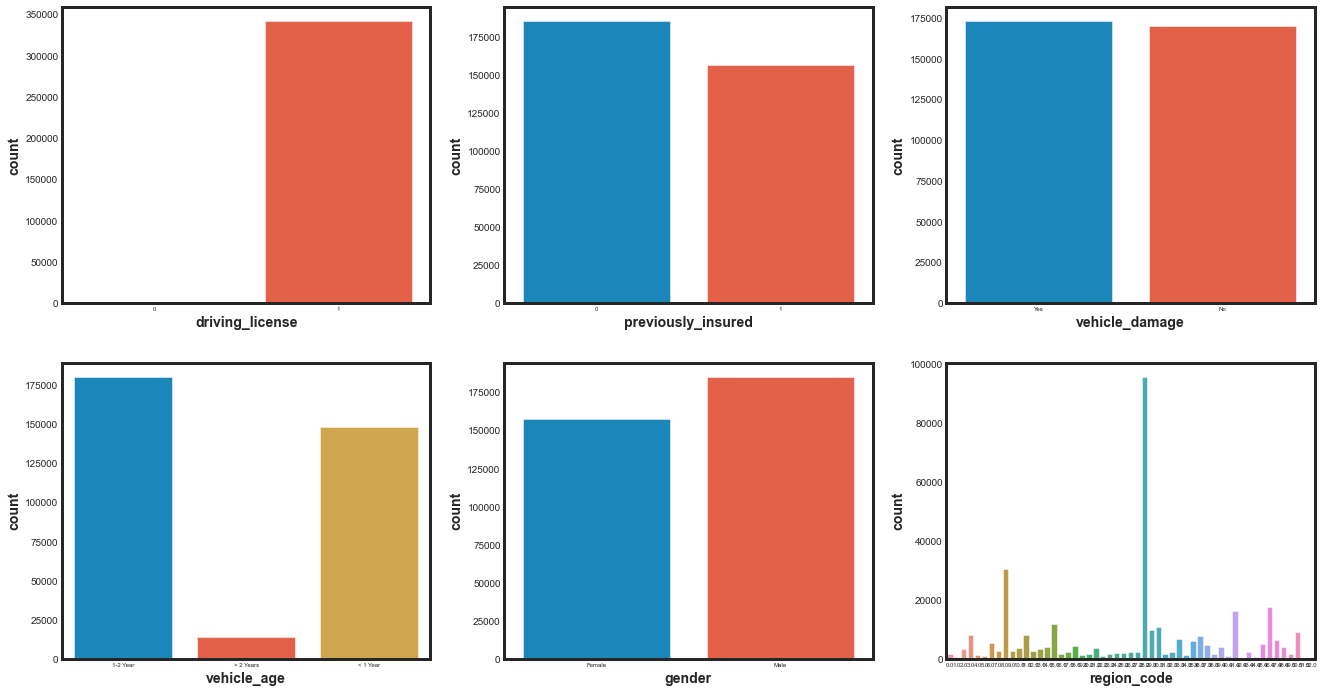

In [23]:
fig, axs = plt.subplots(ncols = 3, nrows = 2,  figsize = (20,12))
sns.countplot( df1['driving_license'],ax=axs[0][0])
sns.countplot( df1['previously_insured'],ax=axs[0][1] )
sns.countplot( df1['vehicle_damage'],ax=axs[0][2] )
sns.countplot( df1['vehicle_age'],ax=axs[1][0] )
sns.countplot( df1['gender'],ax=axs[1][1] )
sns.countplot( df1['region_code'],ax=axs[1][2] )

 ### Target

In [24]:
df1['response'].value_counts()

0    300960
1     42038
Name: response, dtype: int64

<AxesSubplot:xlabel='response', ylabel='count'>

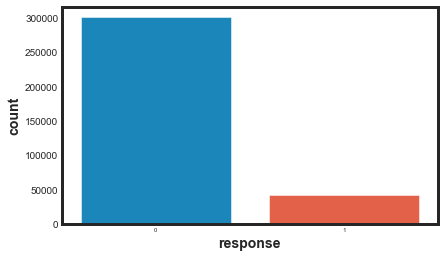

In [25]:
sns.countplot( df1['response'])

## Hypothesis

- People is equaly interested in insurance regardless their gender
**FALSE**
- The older the vehicle the greater is the interest in acquiring an insurance
**TRUE**
- If the owner damaged his vehicle before, he is more likely to acquire an insurance
**TRUE**
- People who has driving license are more interested in insurance
**FALSE**
- Different regions have different interesst in insurance
**TRUE**
- Different policy sales channel have different outcome for the customer
**TRUE**
- Who was previosly insured is less likely to acquire a new insurance service (had already showed commitment)
**TRUE**
- The higher Annual Premium, the lower interest in insurance
**FALSE**
- The higher vintage, the higher interest in insurance
**FALSE**
- The higher age, the higher interest in insurance
**TRUE**

# Feature Engineering

In [26]:
df2 =  df1.copy()

In [27]:
# vehicle age
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' ) 

# vehicle damage
df2['vehicle_damage'] =  df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# EDA

In [28]:
df3 = df2.copy()

In [29]:
aux1 = df3[df3['response'] == 1]
aux2 = df3[df3['response'] == 0]

## People is equaly interested in insurance regardless their gender

In [30]:
aux10=pd.crosstab(df3['gender'], df3['response'])
aux10['percent'] = aux10[1]/(aux10[1]+aux10[0])
aux10

response,0,1,percent
gender,,,
Female,141296,16363,0.10
Male,159664,25675,0.14


## The older the vehicle the greater is the interest in acquiring an insurance


In [31]:
x = aux1['age'].mean()
y = aux2['age'].mean()

print('age of interested     (mean):', x)
print('age of not interested (mean):', y)

age of interested     (mean): 43.420595651553356
age of not interested (mean): 38.17049441786284


<AxesSubplot:xlabel='response', ylabel='age'>

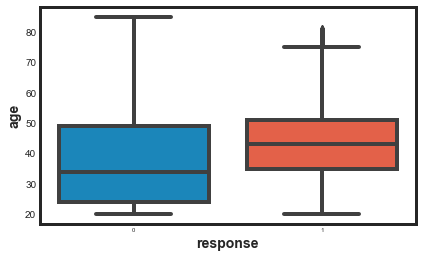

In [32]:
#'age'
sns.boxplot( x='response', y='age', data=df3 )


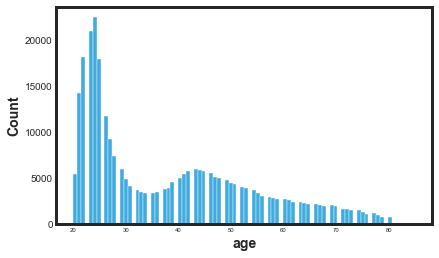

In [33]:
aux00 = df3.loc[df3['response'] == 0, 'age']
sns.histplot( aux00 );

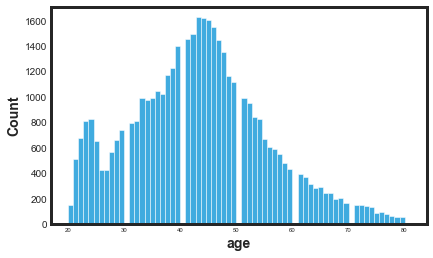

In [34]:
aux00 = df3.loc[df3['response'] == 1, 'age']
sns.histplot( aux00 );

## The older vehicle the greater is the interest in acquiring an insurance


In [35]:
#'vehicle_age'
df3[['vehicle_age', 'response']].value_counts( normalize=True ).reset_index()

,vehicle_age,response,0
0,between_1_2_year,0,0.43
1,below_1_year,0,0.41
2,between_1_2_year,1,0.09
3,over_2_years,0,0.03
4,below_1_year,1,0.02
5,over_2_years,1,0.01


In [36]:
aux9=pd.crosstab(df3['vehicle_age'], df3['response'])
aux9['percent'] = aux9[1]/(aux9[1]+aux9[0])
aux9

response,0,1,percent
vehicle_age,,,
below_1_year,141937,6496,0.04
between_1_2_year,148906,31334,0.17
over_2_years,10117,4208,0.29


,response,vehicle_age,vehicle_age_perc
0,0,300960,0.88
1,1,42038,0.12


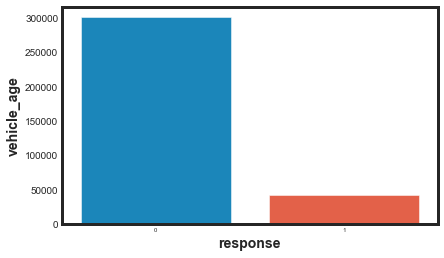

In [37]:
aux = df3[['vehicle_age', 'response']].groupby( 'response' ).count().reset_index()
aux['vehicle_age_perc'] = aux['vehicle_age'] / aux['vehicle_age'].sum()
sns.barplot( x='response', y='vehicle_age', data=aux );
aux.head()

## If the owner *damaged* his vehicle before, he is more likely to acquire an insurance


,response,vehicle_damage,vehicle_damage_perc
0,0,131968,0.76
1,1,41162,0.24


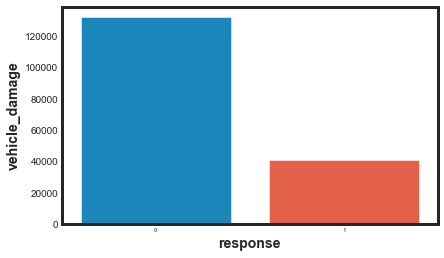

In [38]:
#'vehicle_damage'
aux = df3[['vehicle_damage', 'response']].groupby( 'response' ).sum().reset_index()
aux.head()
aux['vehicle_damage_perc'] = aux['vehicle_damage'] / aux['vehicle_damage'].sum()
sns.barplot( x='response', y='vehicle_damage', data=aux );
aux.head()

## People who has driving license are more interested in insurance


<bound method NDFrame.head of    response  driving_license  driving_license_perc
0         0           300263                  0.88
1         1            42002                  0.12>

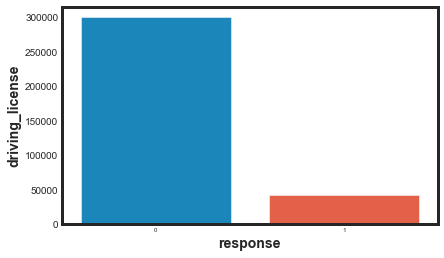

In [39]:
#'driving_license'
aux = df3[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
aux.head()
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
sns.barplot( x='response', y='driving_license', data=aux )
aux.head

 ## Different regions have different interesst in insurance


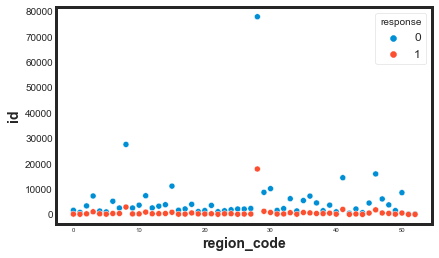

In [40]:
# 'region_code'
aux0 = df3[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()

sns.scatterplot( x='region_code', y='id', hue='response', data=aux0 );

## Different policy sales channel have different outcome for the customer

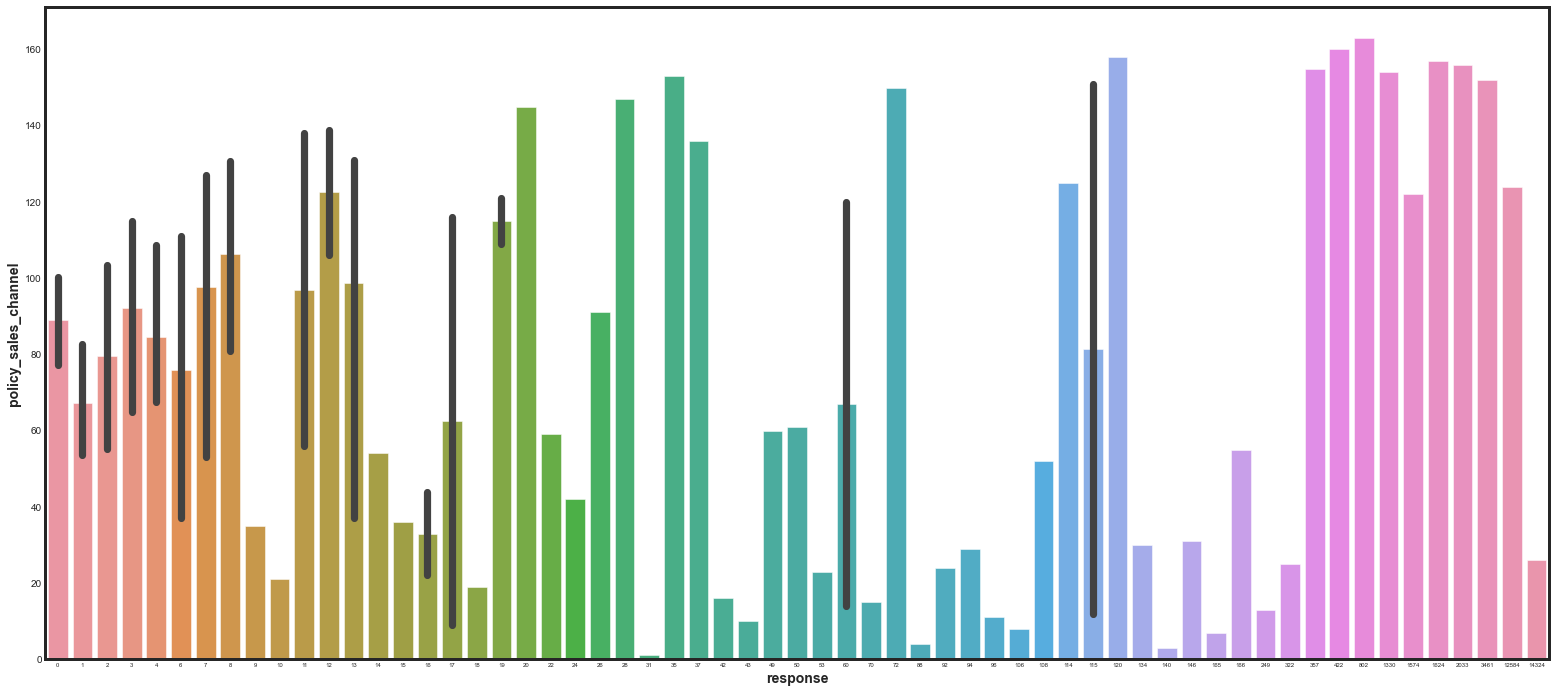

In [41]:
#'policy_sales_channel'
plt.figure( figsize=(24, 12 ))
aux = df3[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel').sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux );

## Who was previosly insured is less likely to acquire a new insurance service (had already showed commitment)


In [42]:
#'previously_insured'
pd.crosstab( df3['previously_insured'], df3['response'] ).apply( lambda x: x / x.sum(), axis=1 )

response,0,1
previously_insured,,
0,0.77,0.23
1,1.00,0.00


## The higher Annual Premium, the lower interest in insurance

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

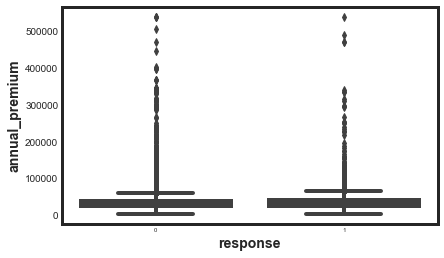

In [43]:
#'annual_premium'
sns.boxplot( x='response', y='annual_premium', data=df3 )

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

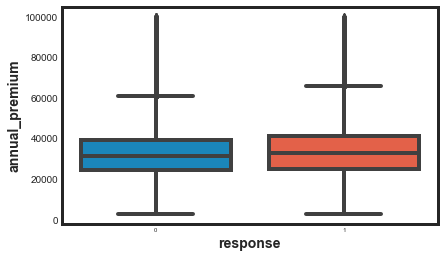

In [44]:
#'annual_premium'
aux = df3[df3['annual_premium'] < 100000]
sns.boxplot( x='response', y='annual_premium', data=aux )

In [45]:
aux1 = df3[df3['response'] == 1]
aux2 = df3[df3['response'] == 0]

x = aux1['annual_premium'].mean()
y = aux2['annual_premium'].mean()

print('Annual premium interested     (mean):', x)
print('Annual premium not interested (mean):', y)

Annual premium interested     (mean): 31613.524929825395
Annual premium not interested (mean): 30420.263965311005


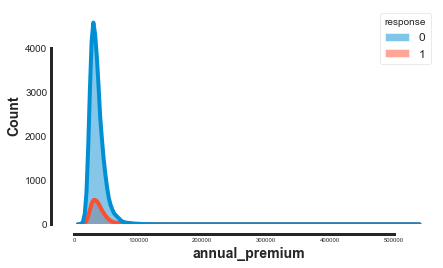

In [46]:
aux3 = df3[df3['annual_premium'] > 3000]

sns.histplot(aux3, x="annual_premium", hue="response", kde = True)
sns.despine(offset = 10, trim = True);

## The higher vintage, the higher interest in insurance

<AxesSubplot:xlabel='vintage', ylabel='Count'>

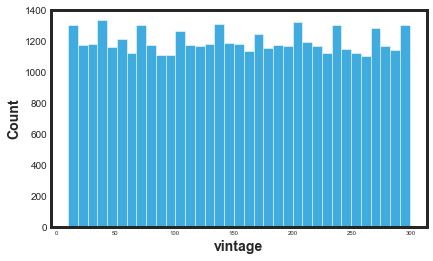

In [47]:
aux00 = df3.loc[df3['response'] == 1, 'vintage']
sns.histplot( aux00 )

<AxesSubplot:xlabel='vintage', ylabel='Count'>

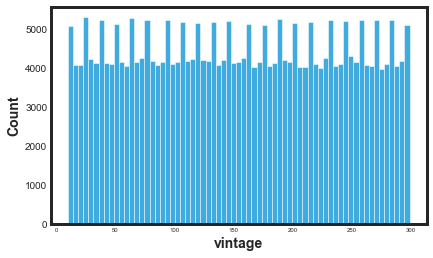

In [48]:
aux00 = df3.loc[df3['response'] == 0, 'vintage']
sns.histplot( aux00 )

In [49]:
x = aux1['vintage'].mean()
y = aux2['vintage'].mean()

print('vintage of interested     (mean):', x)
print('vintage of not interested (mean):', y)

vintage of interested     (mean): 154.0784052523907
vintage of not interested (mean): 154.32007575757575


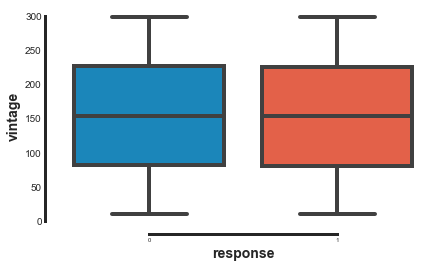

In [50]:
sns.boxplot(x = 'response', y = 'vintage', data = df3)
sns.despine(offset = 10, trim = True);

## The higher age, the higher interest in insurance

In [51]:
x = aux1['age'].mean()
y = aux2['age'].mean()

print('age of interested     (mean):', x)
print('age of not interested (mean):', y)

age of interested     (mean): 43.420595651553356
age of not interested (mean): 38.17049441786284


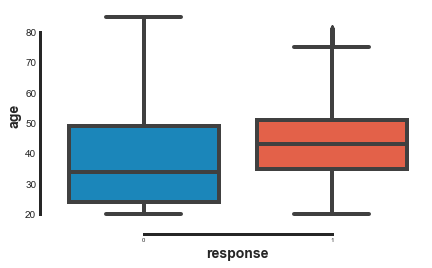

In [52]:
sns.boxplot(x = 'response', y = 'age', data = df3);
sns.despine(offset = 10, trim = True)

## Multivariable Analysis

### Numerical Attributes

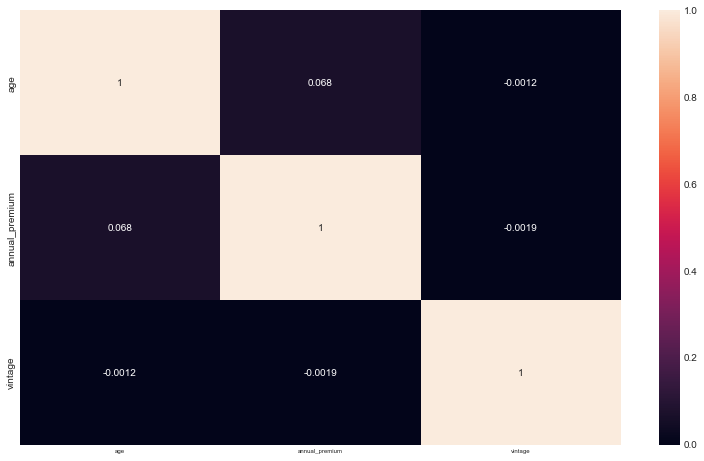

In [53]:
fig = plt.subplots(figsize = (12,8))
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True);

### Categorical Attributes

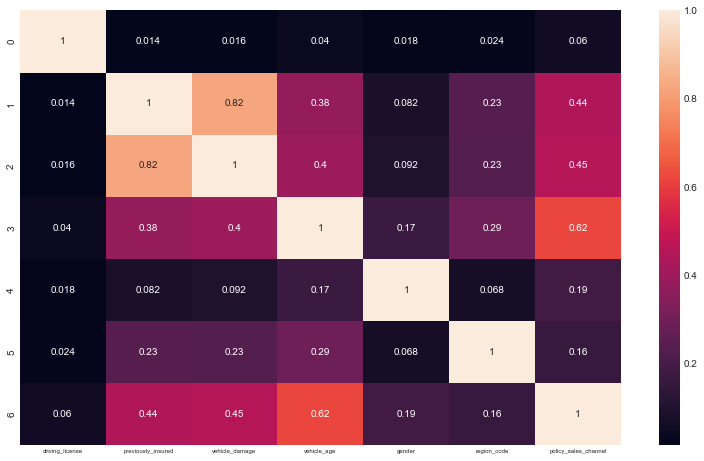

In [54]:
fig = plt.subplots(figsize = (12,8))
sns.heatmap(pd.DataFrame(corr_cramer_v(cat_attributes)), annot=True);

# Data Preparation

In [55]:
df4=df3.copy()

In [56]:
df4.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

In [57]:
df4.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
160482,160483,Female,35,1,39.00,0,between_1_2_year,1,25929.00,127.00,270,0
319511,319512,Female,42,1,2.00,1,between_1_2_year,0,22540.00,152.00,187,0
155501,155502,Male,48,1,28.00,0,over_2_years,1,49425.00,124.00,237,0
148824,148825,Female,24,1,46.00,0,below_1_year,0,32151.00,152.00,61,0
289638,289639,Male,44,1,28.00,0,between_1_2_year,1,27348.00,26.00,163,1


## Standardization

In [58]:
ss = pp.StandardScaler()

# annual_premium
df4['annual_premium'] = ss.fit_transform( df4[['annual_premium']].values )
pkl.dump( ss, open('../health_insurance_cross_sell/src/features/annual_premium_scaler.pkl', 'wb' ) )

## Rescaling

In [59]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age
df4['age'] = mms_age.fit_transform( df4[['age']].values )
pkl.dump( mms_age, open( '../health_insurance_cross_sell/src/features/age_scaler.pkl', 'wb' ) )
# vintage
df4['vintage'] = mms_vintage.fit_transform( df4[['vintage']].values )
pkl.dump( mms_vintage, open( '../health_insurance_cross_sell/src/features/vintage_scaler.pkl', 'wb' ) )

## Encoder

In [60]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df4.groupby('gender')['response'].mean()
df4.loc[:,'gender'] = df4['gender'].map(target_encode_gender)
pkl.dump( target_encode_gender, open('../health_insurance_cross_sell/src/features/target_encode_gender_scaler.pkl', 'wb' ) )

# region_code - Target Encoding / Frequency Encoding
df4['region_code'] = df4['region_code'].astype(np.int64)
target_encode_region_code = df4.groupby( 'region_code' )['response'].mean()
df4.loc[:, 'region_code'] = df4['region_code'].map( target_encode_region_code )
pkl.dump( target_encode_region_code, open( '../health_insurance_cross_sell/src/features/target_encode_region_code_scaler.pkl', 'wb' ) )

# vehicle_age - One Hot Encoding / Frequency Encoding
df4 = pd.get_dummies( df4, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(np.int64)
fe_policy_sales_channel = df4.groupby( 'policy_sales_channel' ).size() / len( df4 ) 
df4.loc[:, 'policy_sales_channel'] = df4['policy_sales_channel'].map( fe_policy_sales_channel )
pkl.dump( fe_policy_sales_channel, open( '../health_insurance_cross_sell/src/features/fe_policy_sales_channel_scaler.pkl', 'wb' ) )

## Train preparation

In [61]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy() 

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20 )

df4 = pd.concat( [x_train, y_train], axis=1 )

# Feature Selection

In [62]:
df5=df4.copy()

## Features Importancia

In [63]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                       vintage        0.27
0                annual_premium        0.24
0                           age        0.17
0                   region_code        0.11
0                vehicle_damage        0.07
0          policy_sales_channel        0.06
0            previously_insured        0.06
0      vehicle_age_below_1_year        0.01
0  vehicle_age_between_1_2_year        0.01
0                        gender        0.01
0      vehicle_age_over_2_years        0.00
0               driving_license        0.00


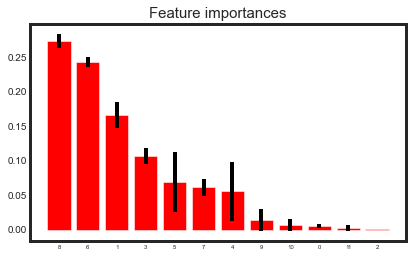

In [64]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

## Boruta

In [65]:
x_train_b = x_train.values
y_train_b = y_train.values.ravel()

rf = RandomForestClassifier( n_jobs=-1)
boruta = BorutaPy(rf,n_estimators='auto',verbose=0,random_state=32).fit(x_train_b,y_train_b)

In [66]:
 #comentado para não fazer o algoritimo do boruta#
cols_selected = boruta.support_.tolist()

#colunas selecionadas
x_train_fs=x_train
cols_selected_boruta = x_train_fs.iloc[:,cols_selected].columns.to_list()

#colunas não selecionadas
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))
print("BorutaSelected Column:")
cols_selected_boruta

BorutaSelected Column:


[]

# Machine Learning

In [100]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'previously_insured',
                 'policy_sales_channel','vehicle_damage']

x_train = df5[cols_selected]
x_val = x_validation[cols_selected]
y_val = y_validation.copy()

## Logistic Regression

In [101]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 ) 

# model training
lr_model.fit( x_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( x_val )

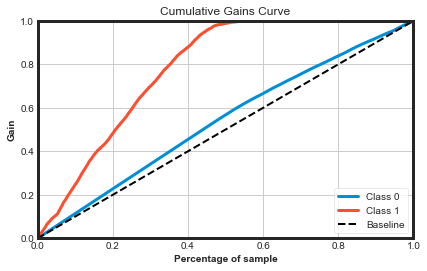

In [102]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

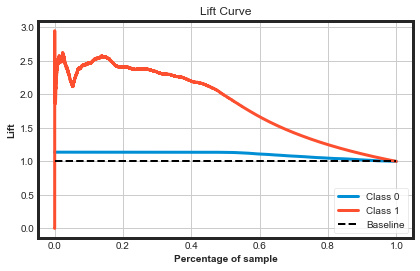

In [103]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_lr );

## KNN

In [98]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )

# model training
knn_model.fit( x_train, y_train )

# model prediction - Poder de GENERALIZACAO 
yhat_knn = knn_model.predict_proba( x_val )

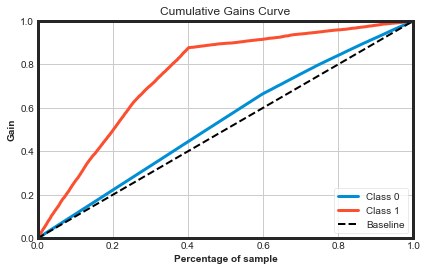

In [72]:
 # Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn );

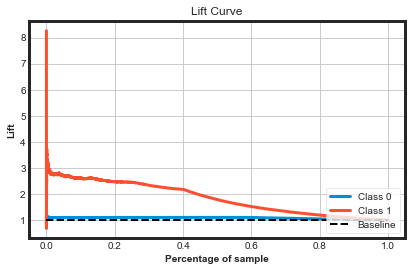

In [74]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_knn );

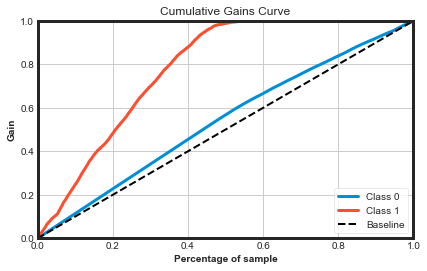

In [73]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

## Extra Trees

In [104]:
# model definition
et = en.ExtraTreesClassifier( n_estimators=1000, n_jobs=-1, random_state=42 )

# model fit
et.fit( x_train, y_train )

# model predict
yhat_et = et.predict_proba( x_val )

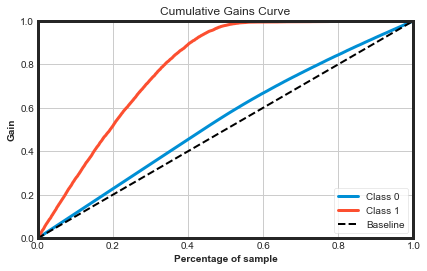

In [106]:
 # Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_et);

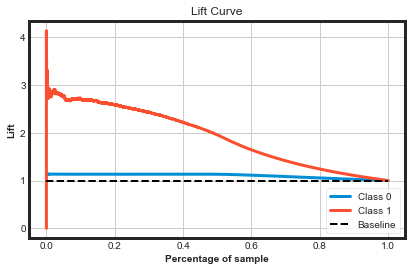

In [79]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_et );

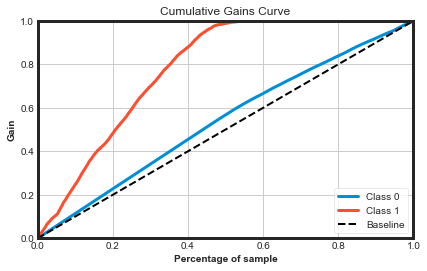

In [107]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

## Random Forest

In [80]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [81]:
# model definition
rf = en.RandomForestClassifier( n_estimators=1000, n_jobs=None, random_state=42 ) 

# model training
rf.fit( x_train, y_train )

# model prediction
yhat_rf = rf.predict_proba( x_val )

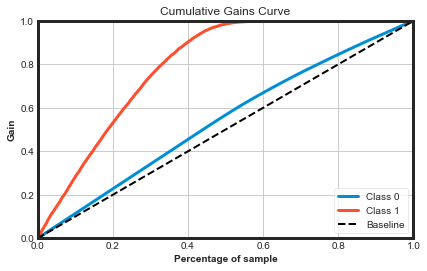

In [82]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_rf );

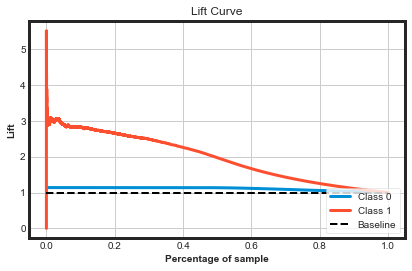

In [84]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_rf );

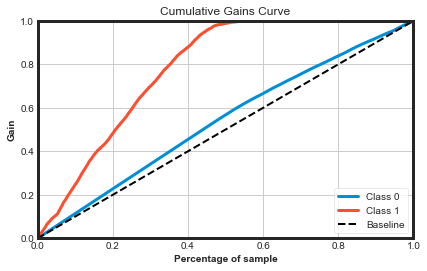

In [83]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

# Model Performance 

## Logistic Regression

In [112]:
# copy data
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['score'] = yhat_lr[:, 1].tolist()

# sorte clients by propensity score
df8 = df8.sort_values( 'score', ascending=False )

# compute precision at k
precision_at_50 = precision_at_k( df8, k=50 )
print( 'Precision at K: {}'.format( precision_at_50 ) )

# compute precision at k
precision_at_50 = recall_at_k( df8, k=50 )
print( 'Recall at K: {}'.format( precision_at_50 ) )

Precision at K: 0.2549019607843137
Recall at K: 0.0015651336383337346


## KNN

In [113]:
# copy data
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['score'] = yhat_knn[:, 1].tolist()

# sorte clients by propensity score
df8 = df8.sort_values( 'score', ascending=False )

# compute precision at k
precision_at_50 = precision_at_k( df8, k=50 )
print( 'Precision at K: {}'.format( precision_at_50 ) )

# compute precision at k
precision_at_50 = recall_at_k( df8, k=50 )
print( 'Recall at K: {}'.format( precision_at_50 ) )

Precision at K: 0.3137254901960784
Recall at K: 0.001926318324103058


## Extra Trees

In [114]:
# copy data
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['score'] = yhat_et[:, 1].tolist()

# sorte clients by propensity score
df8 = df8.sort_values( 'score', ascending=False )

# compute precision at k
precision_at_50 = precision_at_k( df8, k=50 )
print( 'Precision at K: {}'.format( precision_at_50 ) )

# compute precision at k
precision_at_50 = recall_at_k( df8, k=50 )
print( 'Recall at K: {}'.format( precision_at_50 ) )

Precision at K: 0.3333333333333333
Recall at K: 0.0020467132193594992


## Random Forest

In [115]:
# copy data
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['score'] = yhat_rf[:, 1].tolist()

# sorte clients by propensity score
df8 = df8.sort_values( 'score', ascending=False )

# compute precision at k
precision_at_50 = precision_at_k( df8, k=50 )
print( 'Precision at K: {}'.format( precision_at_50 ) )

# compute precision at k
precision_at_50 = recall_at_k( df8, k=50 )
print( 'Recall at K: {}'.format( precision_at_50 ) )

Precision at K: 0.4117647058823529
Recall at K: 0.002528292800385264


# Deploy to Production

In [88]:
# Save trained model
pkl.dump( lr_model, open('../health_insurance_cross_sell/src/models/model_linear_regression.pkl', 'wb' ))

In [89]:
import pickle as pkl
import numpy as np
import pandas as pd


class HealthInsurance( object ):
    
        
    def __init__( self ):
        self.home_path = '/home/alessandra/Repos/health_insurance_cross_sell/health_insurance/'
        self.annual_premium_scaler =            pkl.load( open( self.home_path + 'src/features/annual_premium_scaler.pkl', 'rb' ) )
        self.age_scaler =                       pkl.load( open( self.home_path + 'src/features/age_scaler.pkl', 'rb' ) ) 
        self.vintage_scaler =                   pkl.load( open( self.home_path + 'src/features/vintage_scaler.pkl', 'rb' ) ) 
        self.target_encode_gender_scaler =      pkl.load( open( self.home_path + 'src/features/target_encode_gender_scaler.pkl', 'rb' ) )
        self.target_encode_region_code_scaler = pkl.load( open( self.home_path + 'src/features/target_encode_region_code_scaler.pkl', 'rb' ) )
        self.fe_policy_sales_channel_scaler =   pkl.load( open( self.home_path + 'src/features/fe_policy_sales_channel_scaler.pkl', 'rb' ) )
        
    def data_cleaning( self, df1 ):
        # 1.1. Rename Columns
        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
                    'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage']

        # rename 
        df1.columns = cols_new
        
        df1['region_code'] = df1['region_code'].astype(np.int64)
        df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(np.int64)
        
        return df1 

    
    def feature_engineering( self, df2 ):
        # 2.0. Feature Engineering

        # Vehicle Damage Number
        df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

        # Vehicle Age
        df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )
        
        return df2
    
    
    def data_preparation( self, df5 ):
        # anual premium - StandarScaler
        df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values )

        # Age - MinMaxScaler
        df5['age'] = self.age_scaler.transform( df5[['age']].values )

        # Vintage - MinMaxScaler
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )

        # gender - One Hot Encoding / Target Encoding
        df5.loc[:, 'gender'] = df5['gender'].map( self.target_encode_gender_scaler )

        # region_code - Target Encoding / Frequency Encoding
        df5.loc[:, 'region_code'] = df5['region_code'].map( self.target_encode_region_code_scaler )

        # vehicle_age - One Hot Encoding / Frequency Encoding
        df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

        # policy_sales_channel - Target Encoding / Frequency Encoding
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.fe_policy_sales_channel_scaler )
        
        # Feature Selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                         'policy_sales_channel']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # model prediction
        pred = model.predict_proba( test_data )

        # join prediction into original data
        original_data['score'] = pred[:, 1].tolist()
        
        return original_data.to_json( orient='records', date_format='iso' )


## API Handler

In [116]:
# loading model

import pickle as pkl
import pandas as pd
from flask import Flask, request, Response
from healthinsurance.HealthInsurance import HealthInsurance

#path = ''
#model = pkl.load( open( path +'src/models/model_linear_regression.pkl', 'rb' ) )

path = '/home/alessandra/Repos/pa004_health_insurance_cross_sell/health_insurance/'
model = pkl.load( open( path + 'src/models/model_linear_regression.pkl', 'rb' ) )


# initialize API
app = Flask( __name__ )

@app.route( '/healthinsurance/predict', methods=['POST'] )
def healthinsurance_predict():
    test_json = request.get_json()

    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = HealthInsurance()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run( '0.0.0.0', debug=True )


ModuleNotFoundError: No module named 'healthinsurance'

##  API Tester

In [117]:
# loading test dataset
df_test=df_test.sample(10)
df_test

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
169297,169298,Female,27,1,35.00,1,< 1 Year,No,30266.00,152.00,175
253657,253658,Female,22,1,39.00,1,< 1 Year,No,30346.00,152.00,290
129838,129839,Female,60,1,28.00,1,1-2 Year,No,27717.00,122.00,201
166007,166008,Female,23,1,28.00,1,< 1 Year,No,35414.00,152.00,224
3216,3217,Male,30,1,40.00,1,< 1 Year,No,48317.00,152.00,251
372852,372853,Male,43,1,50.00,0,1-2 Year,No,46304.00,8.00,11
46773,46774,Female,36,1,39.00,0,1-2 Year,Yes,35930.00,86.00,250
261293,261294,Male,46,1,28.00,0,1-2 Year,Yes,39964.00,26.00,131
226784,226785,Male,28,1,50.00,1,< 1 Year,No,34794.00,152.00,168
187078,187079,Male,65,1,47.00,0,1-2 Year,Yes,42159.00,26.00,64


In [118]:
# df_test['Region_Code'] = df_test['Region_Code'].astype(np.int64)
# df_test['Policy_Sales_Channel'] = df_test['Policy_Sales_Channel'].astype(np.int64)
# df_test['Annual_Premium'] = df_test['Annual_Premium'].astype(np.int64)

# df_test.fillna(999, inplace=True)


In [119]:
print( 'Number of Rows: {}'.format( df_test.shape[0] ) )
print( 'Number of Columns: {}'.format( df_test.shape[1] ) )

Number of Rows: 10
Number of Columns: 11


In [120]:
# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [121]:
data

'[{"id": 169298, "Gender": "Female", "Age": 27, "Driving_License": 1, "Region_Code": 35.0, "Previously_Insured": 1, "Vehicle_Age": "< 1 Year", "Vehicle_Damage": "No", "Annual_Premium": 30266.0, "Policy_Sales_Channel": 152.0, "Vintage": 175}, {"id": 253658, "Gender": "Female", "Age": 22, "Driving_License": 1, "Region_Code": 39.0, "Previously_Insured": 1, "Vehicle_Age": "< 1 Year", "Vehicle_Damage": "No", "Annual_Premium": 30346.0, "Policy_Sales_Channel": 152.0, "Vintage": 290}, {"id": 129839, "Gender": "Female", "Age": 60, "Driving_License": 1, "Region_Code": 28.0, "Previously_Insured": 1, "Vehicle_Age": "1-2 Year", "Vehicle_Damage": "No", "Annual_Premium": 27717.0, "Policy_Sales_Channel": 122.0, "Vintage": 201}, {"id": 166008, "Gender": "Female", "Age": 23, "Driving_License": 1, "Region_Code": 28.0, "Previously_Insured": 1, "Vehicle_Age": "< 1 Year", "Vehicle_Damage": "No", "Annual_Premium": 35414.0, "Policy_Sales_Channel": 152.0, "Vintage": 224}, {"id": 3217, "Gender": "Male", "Age": 

In [122]:
# API Call
#url = 'http://0.0.0.0:5000/healthinsurance/predict'
url = 'https://health-insurance-ab.herokuapp.com/healthinsurance/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [123]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'score', ascending=False ).head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,score
7,261294,0.14,0.40,1,0.19,0,between_1_2_year,1,0.55,26.00,0.42,0.29
6,46774,0.10,0.25,1,0.12,0,between_1_2_year,1,0.31,86.00,0.83,0.27
9,187079,0.14,0.69,1,0.08,0,between_1_2_year,1,0.67,26.00,0.19,0.19
5,372853,0.14,0.35,1,0.06,0,between_1_2_year,0,0.91,8.00,0.00,0.03
2,129839,0.10,0.62,1,0.19,1,between_1_2_year,0,-0.16,122.00,0.66,0.00
